In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout,GRU
from keras import optimizers 

seed = 1234
np.random.seed(seed)
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2025-09-10 23:07:46.256039: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-10 23:07:47.106028: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-10 23:07:49.401591: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
dataraw = pd.read_csv('./BTC-USD.csv',index_col='Date', parse_dates=['Date'])
dataraw

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2020-07-05,9126.090820,9162.183594,8977.015625,9073.942383,9073.942383,12903406143
2020-07-06,9072.849609,9375.474609,9058.664063,9375.474609,9375.474609,17889263252
2020-07-07,9349.161133,9360.617188,9201.815430,9252.277344,9252.277344,13839652595


 Count row of data:  2123


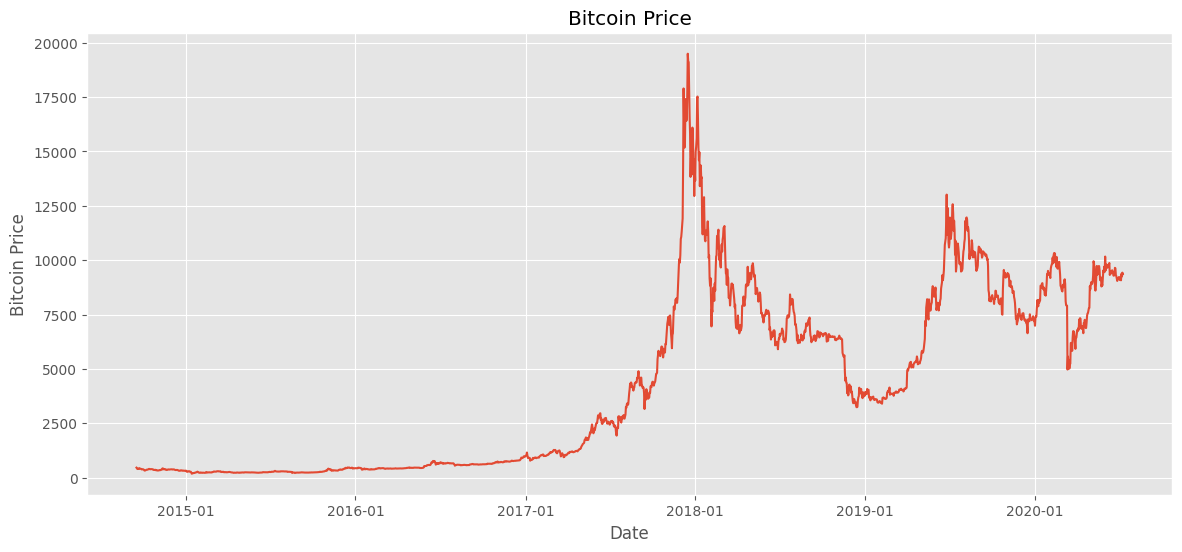

In [3]:
# use feature 'Date' & 'Close'
dataset = pd.DataFrame(dataraw['Close'])
print(' Count row of data: ',len(dataset))

fig = plt.figure(figsize=(14, 6))
plt.plot(dataset)
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Bitcoin Price')
plt.show()

In [4]:
#Min-Max Normalization
dataset_norm = dataset.copy()
dataset[['Close']]
scaler = MinMaxScaler()
dataset_norm['Close'] = scaler.fit_transform(dataset[['Close']])
dataset_norm

,Close
Date,
2014-09-17,0.014453
2014-09-18,0.012751
2014-09-19,0.011216
2014-09-20,0.011947
2014-09-21,0.011425
...,...
2020-07-05,0.460464
2020-07-06,0.476072
2020-07-07,0.469695


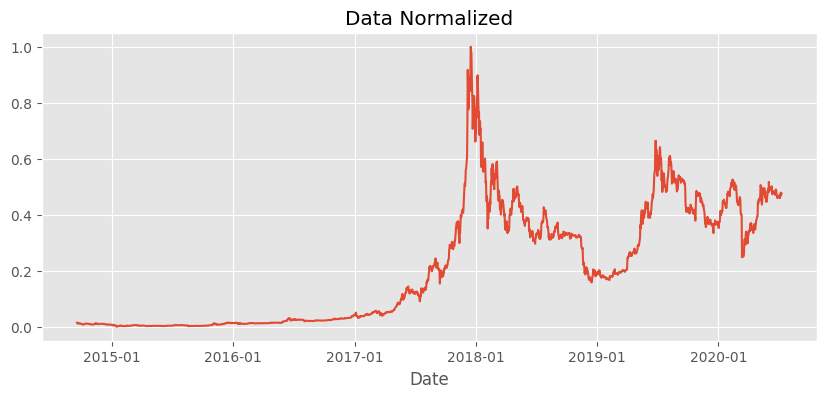

In [5]:
fig = plt.figure(figsize=(10, 4))
plt.plot(dataset_norm)
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Normalized')
plt.show()

In [6]:
# Partition data into data train, val & test
totaldata = dataset.values
totaldatatrain = int(len(totaldata)*0.7)
totaldataval = int(len(totaldata)*0.1)
totaldatatest = int(len(totaldata)*0.2)

# Store data into each partition
training_set = dataset_norm[0:totaldatatrain]
val_set=dataset_norm[totaldatatrain:totaldatatrain+totaldataval]
test_set = dataset_norm[totaldatatrain+totaldataval:]

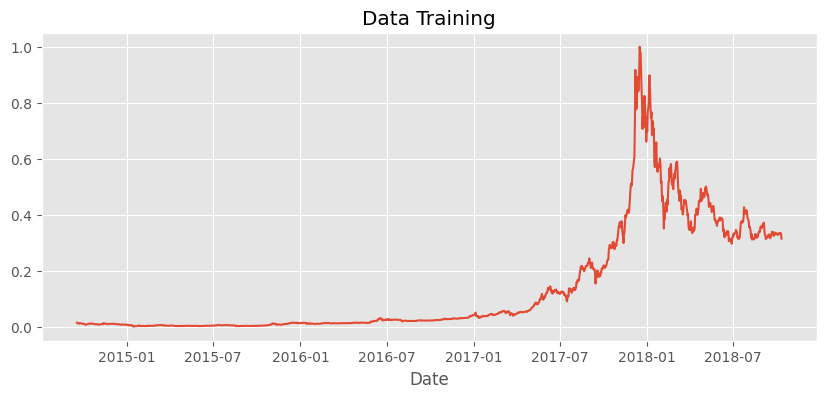

In [7]:
# graph of data training
fig = plt.figure(figsize=(10, 4))
plt.plot(training_set)
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Training')
plt.show()

In [8]:
# Initiaton value of lag
lag = 2
# sliding windows function
def create_sliding_windows(data,len_data,lag):
    x=[]
    y=[]
    for i in range(lag,len_data):
        x.append(data[i-lag:i,0])
        y.append(data[i,0]) 
        
    return np.array(x),np.array(y)

# Formating data into array for create sliding windows
array_training_set = np.array(training_set)
array_val_set = np.array(val_set)
array_test_set = np.array(test_set)

# Create sliding windows into training data
x_train, y_train = create_sliding_windows(array_training_set,len(array_training_set), lag)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# Create sliding windows into validation data
x_val,y_val = create_sliding_windows(array_val_set,len(array_val_set),lag)
x_val = np.reshape(x_val, (x_val.shape[0],x_val.shape[1],1))
# Create sliding windows into test data
x_test,y_test = create_sliding_windows(array_test_set,len(array_test_set),lag)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))


In [9]:
# Hyperparameters
learning_rate = 0.0001
hidden_unit = 64
batch_size=256
epoch = 100

# Architecture Gated Recurrent Unit
regressorGRU = Sequential()

# First GRU layer with dropout
regressorGRU.add(GRU(units=hidden_unit, return_sequences=True, input_shape=(x_train.shape[1],1), activation = 'tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer with dropout
regressorGRU.add(GRU(units=hidden_unit, return_sequences=True, activation = 'tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer with dropout
regressorGRU.add(GRU(units=hidden_unit, return_sequences=False, activation = 'tanh'))
regressorGRU.add(Dropout(0.2))

# Output layer
regressorGRU.add(Dense(units=1))

# Compiling the Gated Recurrent Unit
regressorGRU.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),loss='mean_squared_error')
print(x_train.shape[1],1)
regressorGRU.summary()
# Fitting ke data training dan data validation
pred = regressorGRU.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size=batch_size, epochs=epoch)

2 1


2025-09-10 23:07:50.301891: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/jack/Documents/synth-subnet/bt_venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 2, 64)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 2, 64)          │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,849 (245.50 KB)

 Trainable params: 62,849 (245.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0569 - val_loss: 0.0499
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0528 - val_loss: 0.0443
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0491 - val_loss: 0.0391
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0454 - val_loss: 0.0342
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0425 - val_loss: 0.0296
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0398 - val_loss: 0.0253
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0371 - val_loss: 0.0213
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0346 - val_loss: 0.0176
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0326 - val_loss: 0.0143
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0306 - val_loss: 0.0115
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0288 - val_loss: 0.0092
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0277 - val_lo

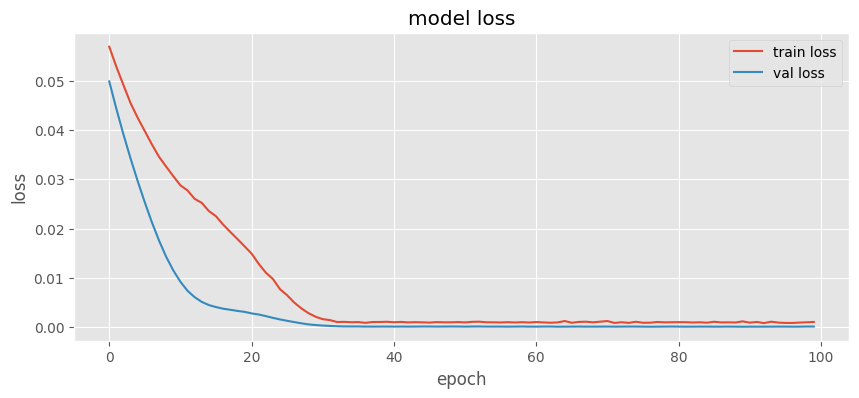

In [12]:
# Graph model loss (train loss & val loss)
fig = plt.figure(figsize=(10, 4))
plt.plot(pred.history['loss'], label='train loss')
plt.plot(pred.history['val_loss'], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [13]:
# Implementation model into data test
y_pred_test = regressorGRU.predict(x_test)

# Invert normalization min-max
y_pred_invert_norm = scaler.inverse_transform(y_pred_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [27]:
y_pred_invert_norm, x_test

(array([[ 7042.9893],
        [ 7675.2764],
        [ 7862.432 ],
        [ 7910.232 ],
        [ 7526.4834],
        [ 7133.538 ],
        [ 7363.4736],
        [ 7933.403 ],
        [ 7778.105 ],
        [ 7682.0435],
        [ 7548.619 ],
        [ 7719.1177],
        [ 7811.3535],
        [ 8044.264 ],
        [ 8511.812 ],
        [ 8577.056 ],
        [ 8499.55  ],
        [ 8354.59  ],
        [ 8197.989 ],
        [ 8370.362 ],
        [ 8417.501 ],
        [ 8378.487 ],
        [ 7859.1797],
        [ 7550.2095],
        [ 7629.4995],
        [ 7695.1533],
        [ 7820.4194],
        [ 7678.1514],
        [ 7589.9624],
        [ 7782.447 ],
        [ 7798.6235],
        [ 7974.347 ],
        [ 8173.259 ],
        [ 8535.924 ],
        [ 8683.011 ],
        [ 8889.836 ],
        [ 9042.005 ],
        [ 8935.789 ],
        [ 9145.417 ],
        [ 9508.964 ],
        [10106.426 ],
        [10539.52  ],
        [10693.8125],
        [11041.061 ],
        [11959.51  ],
        [1

In [14]:
myxtest = np.array([[[0.2],[0.5]]])
myxtest

array([[[0.2],
        [0.5]]])

In [15]:
myytest = regressorGRU.predict(myxtest)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [16]:
myytest
myxtest[0,0] = myxtest[0,1]
myxtest[0,1] = myytest[0,0]
myytest = regressorGRU.predict(myxtest)
myytest

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[0.42311236]], dtype=float32)

In [17]:
myytest = regressorGRU.predict(myxtest)
myy = []
myy.append(myytest[0,0])
for i in range(1000):
    myxtest[0,0] = myxtest[0,1]
    myxtest[0,1] = myytest[0,0]
    print(i)
    print(myxtest)
    myytest = regressorGRU.predict(myxtest)
    myy.append(myytest[0,0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
0
[[[0.28303334]
  [0.42311236]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1
[[[0.42311236]
  [0.31671846]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2
[[[0.31671846]
  [0.38056344]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3
[[[0.38056344]
  [0.32696655]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4
[[[0.32696655]
  [0.35450858]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
5
[[[0.35450858]
  [0.32613912]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6
[[[0.32613912]
  [0.33643293]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7
[[[0.33643293]
  [0.32014078]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
8
[[[0.32014078]
  [0.32227579]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
9
[[[0.32227579]
  [0.31179342]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
10
[[[0.31179342]
  [0.31010413]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
11
[[[0.31010413]
  [0.30244711]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
12
[[[0.30244711]
  [0.29899999]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13
[[[0.29899999]
  [0.

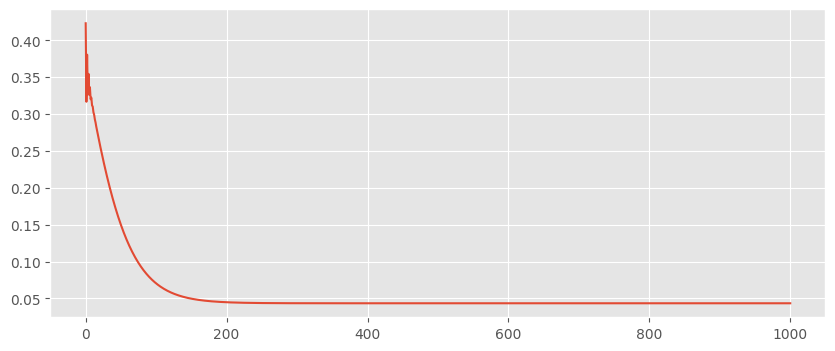

In [18]:
# graph of data test
fig = plt.figure(figsize=(10, 4))
plt.plot(myy)
plt.show()

In [19]:
# Implementation model into data test
y_pred_test = regressorGRU.predict(x_test)

# Invert normalization min-max
y_pred_invert_norm = scaler.inverse_transform(y_pred_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [23]:
y_pred_invert_norm

array([[ 7042.9893],
       [ 7675.2764],
       [ 7862.432 ],
       [ 7910.232 ],
       [ 7526.4834],
       [ 7133.538 ],
       [ 7363.4736],
       [ 7933.403 ],
       [ 7778.105 ],
       [ 7682.0435],
       [ 7548.619 ],
       [ 7719.1177],
       [ 7811.3535],
       [ 8044.264 ],
       [ 8511.812 ],
       [ 8577.056 ],
       [ 8499.55  ],
       [ 8354.59  ],
       [ 8197.989 ],
       [ 8370.362 ],
       [ 8417.501 ],
       [ 8378.487 ],
       [ 7859.1797],
       [ 7550.2095],
       [ 7629.4995],
       [ 7695.1533],
       [ 7820.4194],
       [ 7678.1514],
       [ 7589.9624],
       [ 7782.447 ],
       [ 7798.6235],
       [ 7974.347 ],
       [ 8173.259 ],
       [ 8535.924 ],
       [ 8683.011 ],
       [ 8889.836 ],
       [ 9042.005 ],
       [ 8935.789 ],
       [ 9145.417 ],
       [ 9508.964 ],
       [10106.426 ],
       [10539.52  ],
       [10693.8125],
       [11041.061 ],
       [11959.51  ],
       [12247.018 ],
       [11349.518 ],
       [12063

In [20]:
# Comparison data test with data prediction
datacompare = pd.DataFrame()
datatest=np.array(dataset['Close'][totaldatatrain+totaldataval+lag:])
datapred= y_pred_invert_norm

datacompare['Data Test'] = datatest
datacompare['Prediction Results'] = datapred
# Calculatre value of Root Mean Square Error 
def rmse(datatest, datapred):
    return np.round(np.sqrt(np.mean((datapred - datatest) ** 2)), 4)
print('Result Root Mean Square Error Prediction Model :',rmse(datatest, datapred))

def mape(datatest, datapred): 
    return np.round(np.mean(np.abs((datatest - datapred) / datatest) * 100), 4)
    
print('Result Mean Absolute Percentage Error Prediction Model : ', mape(datatest, datapred), '%')

Result Root Mean Square Error Prediction Model : 1987.5914
Result Mean Absolute Percentage Error Prediction Model :  18.4602 %


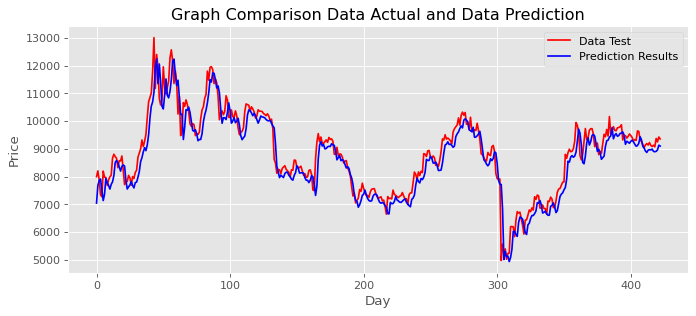

In [21]:
# Create graph data test and prediction result
plt.figure(num=None, figsize=(10, 4), dpi=80,facecolor='w', edgecolor='k')
plt.title('Graph Comparison Data Actual and Data Prediction')
plt.plot(datacompare['Data Test'], color='red',label='Data Test')
plt.plot(datacompare['Prediction Results'], color='blue',label='Prediction Results')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

In [22]:
for i in range(y_test.shape[0]):
    print(x_test[i])
    print(y_test[i])

[[0.35168301]
 [0.3952945 ]]
0.4045857807350749
[[0.3952945 ]
 [0.40458578]]
0.4154946636366012
[[0.40458578]
 [0.41549466]]
0.39891751890482435
[[0.41549466]
 [0.39891752]]
0.37091372244191434
[[0.39891752]
 [0.37091372]]
0.3671512926536376
[[0.37091372]
 [0.36715129]]
0.415107562809492
[[0.36715129]
 [0.41510756]]
0.4037520581792103
[[0.41510756]
 [0.40375206]]
0.40297659286620013
[[0.40375206]
 [0.40297659]]
0.3883145052530846
[[0.40297659]
 [0.38831451]]
0.3987589986471928
[[0.38831451]
 [0.398759  ]]
0.4042211487375079
[[0.398759  ]
 [0.40422115]]
0.4075945821328453
[[0.40422115]
 [0.40759458]]
0.4397216239384592
[[0.40759458]
 [0.43972162]]
0.4465832865187988
[[0.43972162]
 [0.44658329]]
0.44214128201654945
[[0.44658329]
 [0.44214128]]
0.4390110124332513
[[0.44214128]
 [0.43901101]]
0.42141127047145516
[[0.43901101]
 [0.42141127]]
0.43461202471277693
[[0.42141127]
 [0.43461202]]
0.43406928494400043
[[0.43461202]
 [0.43406928]]
0.44333159932117006
[[0.43406928]
 [0.4433316 ]]
0.41